<a href="https://colab.research.google.com/github/avocadopelvis/BTP/blob/main/lung-segmentation/ls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install keras_unet_collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# load libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import cv2
from cv2 import imread, createCLAHE
from tqdm import tqdm
from glob import glob

from sklearn.model_selection import train_test_split

In [4]:
# dataset path
image_path = os.path.join("/content/drive/MyDrive/BTP/LUNG SEGMENTATION/DATASET/CXR_png")
mask_path = os.path.join("/content/drive/MyDrive/BTP/LUNG SEGMENTATION/DATASET/masks")

#### Since we have 800 images but only 704 masks, we will make a 1-1 correspondence from masks to images

In [5]:
image = os.listdir(image_path)
mask = os.listdir(mask_path)
# get the file name of each mask and store in a list
masks = [fName.split(".png")[0] for fName in mask]
# get the corresponding image file name for each mask and store in a list
images = [fName.split("_mask")[0] for fName in masks]

In [6]:
check = [i for i in masks if "mask" in i]
print("Total mask that has modified name:", len(check))

Total mask that has modified name: 566


In [7]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

# function to get data
def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array
    
    
# function to perform sanity check
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [8]:
# load data
dim = 256*2
X_train, y_train = getData(dim, flag = 'train')
X_test, y_test = getData(dim)

100%|██████████| 138/138 [00:51<00:00,  2.67it/s]


### Perform Sanity Check

training set


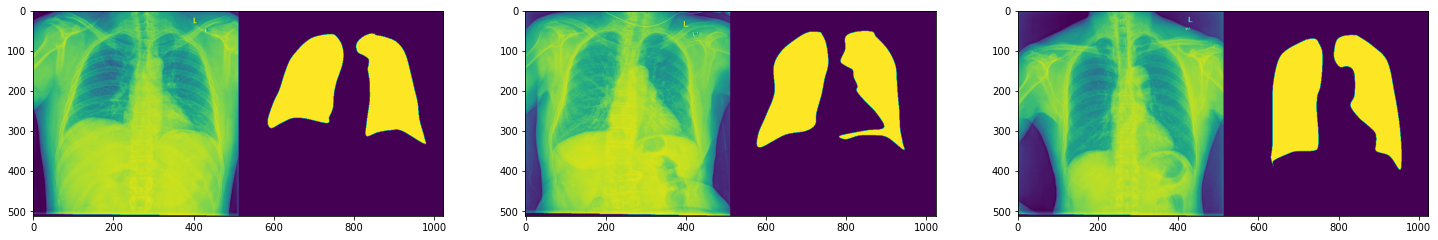

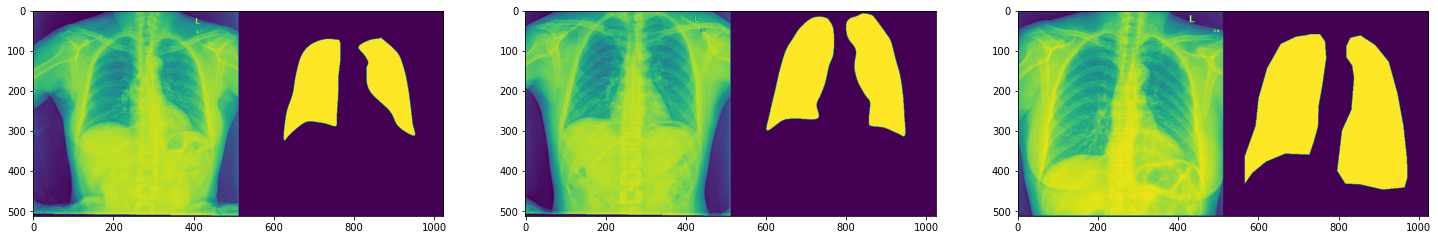

testing set


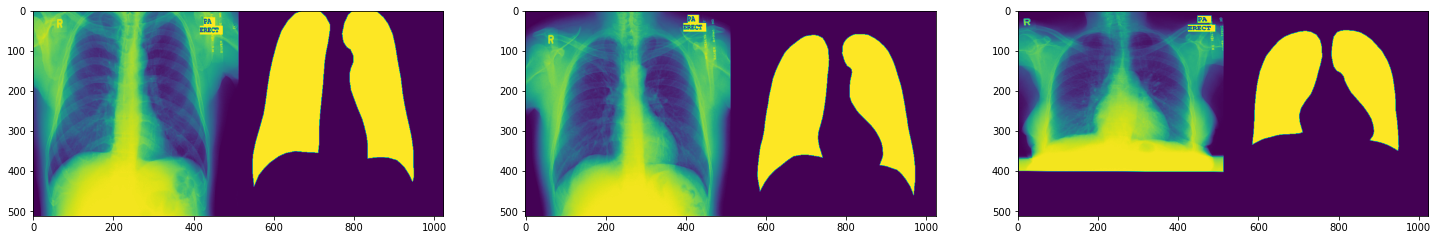

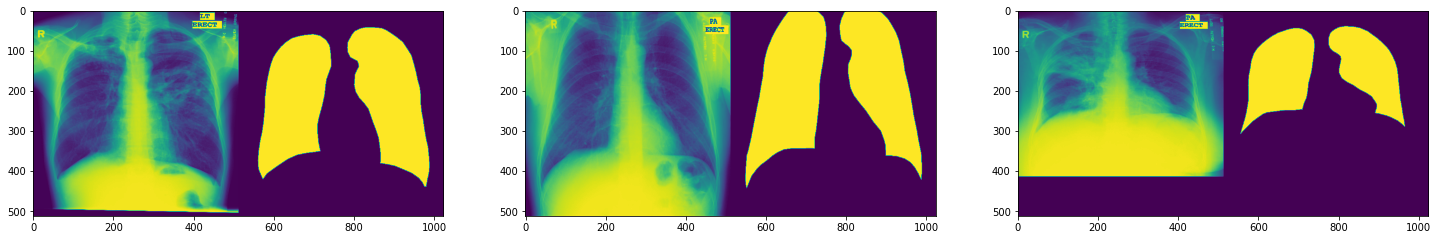

In [9]:
print("training set")
plotMask(X_train, y_train)
print('testing set')
plotMask(X_test, y_test)

#### Since both the sets look correct, we will combine them and use it as a unified dataset

In [10]:
X_train = np.array(X_train).reshape(len(X_train), dim, dim, 1)
y_train = np.array(y_train).reshape(len(y_train), dim, dim, 1)
X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)
y_test = np.array(y_test).reshape(len(y_test), dim, dim, 1)

assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape

images = np.concatenate((X_train, X_test), axis = 0)
masks = np.concatenate((y_train, y_test), axis = 0)

In [ ]:
# split the data into train, validation and test sets
train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (masks>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 42)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 42)

In [11]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [35]:
# Hyperparameters
batch_size = 16
epochs = 3
# loss = "categorical_crossentropy"

In [44]:
from tensorflow.keras.optimizers import *
# from keras.optimizers import Adam 
from keras_unet_collection import models

# model = models.unet_2d((512, 512, 2), [32, 64, 128, 256, 512], 2)
model = unet(input_size=(512,512,1))
# model.compile(optimizer = Adam(learning_rate = 1e-5), 
#               loss = dice_coef_loss,
#               metrics = [dice_coef, 'binary_accuracy'])
# model.summary()

model.compile(optimizer = Adam(learning_rate = 2e-4), 
              loss = [dice_coef_loss], 
              metrics = [dice_coef, 'binary_accuracy'])

In [45]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', min_delta = 0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
                      
callbacks = [checkpoint, early, reduceLROnPlat]

In [46]:
# train the model
history = model.fit(x = train_vol,
                    y = train_seg,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (test_vol, test_seg),
                    callbacks = callbacks)

Epoch 1/3
36/36 [==============================] - ETA: 0s - loss: -0.3856 - dice_coef: 0.3861 - binary_accuracy: 0.4061
Epoch 1: val_loss improved from inf to -0.46570, saving model to cxr_reg_weights.best.hdf5
36/36 [==============================] - 43s 1s/step - loss: -0.3856 - dice_coef: 0.3861 - binary_accuracy: 0.4061 - val_loss: -0.4657 - val_dice_coef: 0.4657 - val_binary_accuracy: 0.5993 - lr: 2.0000e-04
Epoch 2/3
36/36 [==============================] - ETA: 0s - loss: -0.5612 - dice_coef: 0.5615 - binary_accuracy: 0.6955
Epoch 2: val_loss improved from -0.46570 to -0.70322, saving model to cxr_reg_weights.best.hdf5
36/36 [==============================] - 42s 1s/step - loss: -0.5612 - dice_coef: 0.5615 - binary_accuracy: 0.6955 - val_loss: -0.7032 - val_dice_coef: 0.7032 - val_binary_accuracy: 0.8032 - lr: 2.0000e-04
Epoch 3/3
36/36 [==============================] - ETA: 0s - loss: -0.7406 - dice_coef: 0.7417 - binary_accuracy: 0.8413
Epoch 3: val_loss improved from -0.703

In [16]:
# # save the model
# model.save("lung-model.h5")
# # load the model
# model = keras.models.load_model("lung-model.h5")

### Plot the metric & evaluate

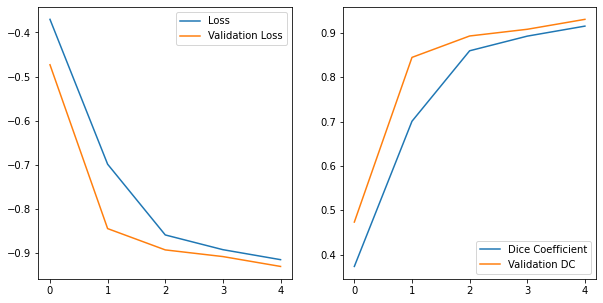

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

# ax2.plot(100*np.array(history.history['binary_accuracy']), '-', 
#          label = 'Accuracy')
# ax2.plot(100*np.array(history.history['val_binary_accuracy']), '-',
#          label = 'Validation Accuracy')
# ax2.legend()

ax2.plot(history.history["dice_coef"], label = "Dice Coefficient")
ax2.plot(history.history["val_dice_coef"], label = "Validation DC")
ax2.legend()

### Test the model

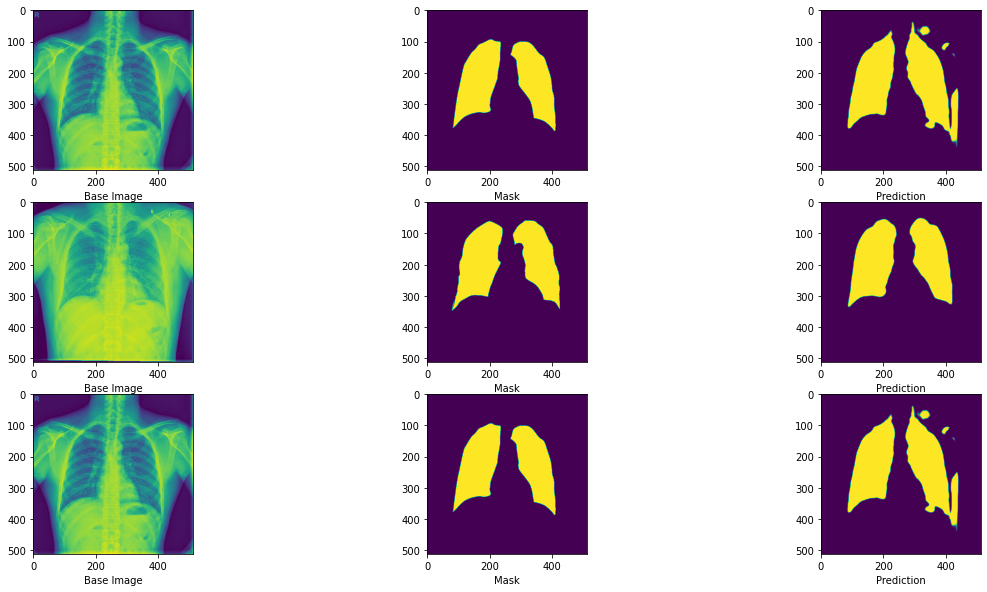

In [18]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Prediction")